In [1]:
# Import Global Dependencies
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch
import torch.nn.functional as F
# Import Helper Libaries
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import random
import copy

device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#### CNN Definition

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layer
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        # Output layer
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Convolutional layer 1 with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Convolutional layer 2 with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output for the fully connected layer
        x = x.view(-1, 64 * 4 * 4)
        # Fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Output layer with softmax activation
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [4]:
def client_update(client_model, optimizer, train_loader, epochs):
    model.train()
    
    for i in range(epochs):
        for batch_index, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = client_model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
    return loss.item()

In [5]:
def server_average(global_model, client_models):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
         global_dict[k] = torch.stack([client_models[i].state_dict()[k] for i in range(len(client_models))], 0).mean(0)
            
    global_model.load_state_dict(global_dict)
    
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

In [6]:
def test(global_model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = global_model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    return test_loss, acc

In [7]:
import time 
num_clients = 100 #Number of total clients
num_selected = 10 #Selection of clients
num_rounds = 1200   # Number of rounds t
epochs = 5           #E epochs
batch_size = 10  # mini batches

# Creating decentralized datasets

traindata = datasets.MNIST('./data', train=True, download=True, transform=transform)

traindata_split = torch.utils.data.random_split(traindata, [int(traindata.data.shape[0] / num_clients) for _ in range(num_clients)])
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transform
        ), batch_size=batch_size, shuffle=True)

# Instantiate models and optimizers

global_model = CNN().to(device)
client_models = [CNN().to(device) for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())

opt = [optim.SGD(model.parameters(), lr=0.215) for model in client_models]

# Runnining FL
IID_accuracy_list = []
IID_avg_training_losses = []
IID_eval_losses = []
for r in range(num_rounds):
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]
    # client update
    loss = 0
    # Go through the selected clients
    for i in range(num_selected):
        loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], epochs=epochs)  
    # serer aggregate
    server_average(global_model, client_models)
    test_loss, acc = test(global_model, test_loader)
    IID_accuracy_list.append(acc)
    IID_eval_losses.append(test_loss)
    avg_training_loss = loss/ num_selected
    IID_avg_training_losses.append(avg_training_loss)
    if(r % 10 == 0):
        print('%d-th round' % r)
        print('average train loss %0.3g | test loss %0.3g | test acc: %0.5f' % (avg_training_loss, test_loss, acc))
        
torch.save(global_model,'IID_Model')
IID_MODEL = torch.load('IID_Model')


0-th round
average train loss 1.63 | test loss 1.61 | test acc: 0.86010
10-th round
average train loss 1.48 | test loss 1.48 | test acc: 0.98250
20-th round
average train loss 1.5 | test loss 1.47 | test acc: 0.98640
30-th round
average train loss 1.47 | test loss 1.47 | test acc: 0.98690
40-th round
average train loss 1.46 | test loss 1.47 | test acc: 0.98880
50-th round
average train loss 1.47 | test loss 1.47 | test acc: 0.98950
60-th round
average train loss 1.47 | test loss 1.47 | test acc: 0.98870
70-th round
average train loss 1.48 | test loss 1.47 | test acc: 0.98960
80-th round
average train loss 1.49 | test loss 1.47 | test acc: 0.99050
90-th round
average train loss 1.47 | test loss 1.47 | test acc: 0.99060
100-th round
average train loss 1.46 | test loss 1.47 | test acc: 0.99000
110-th round
average train loss 1.48 | test loss 1.47 | test acc: 0.99200
120-th round
average train loss 1.46 | test loss 1.47 | test acc: 0.99180
130-th round
average train loss 1.47 | test loss 1

NameError: name 'poggers' is not defined

In [8]:
IID_SUMMARY= summary(IID_MODEL, (1, 28, 28),verbose=2, col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])

Layer (type (var_name))                  Kernel Shape     Output Shape     Param #          Mult-Adds
CNN (CNN)                                --               [1, 10]          --               --
├─Conv2d (conv1)                         [5, 5]           [32, 24, 24]     832              638,976
│    └─weight                            [1, 32, 5, 5]                     ├─800
│    └─bias                              [32]                              └─32
├─MaxPool2d (pool)                       2                [32, 12, 12]     --               --
├─Conv2d (conv2)                         [5, 5]           [64, 8, 8]       51,264           26,247,168
│    └─weight                            [32, 64, 5, 5]                    ├─51,200
│    └─bias                              [64]                              └─64
├─MaxPool2d (pool)                       2                [64, 4, 4]       --               --
├─Linear (fc1)                           --               [1, 512]         524,800   

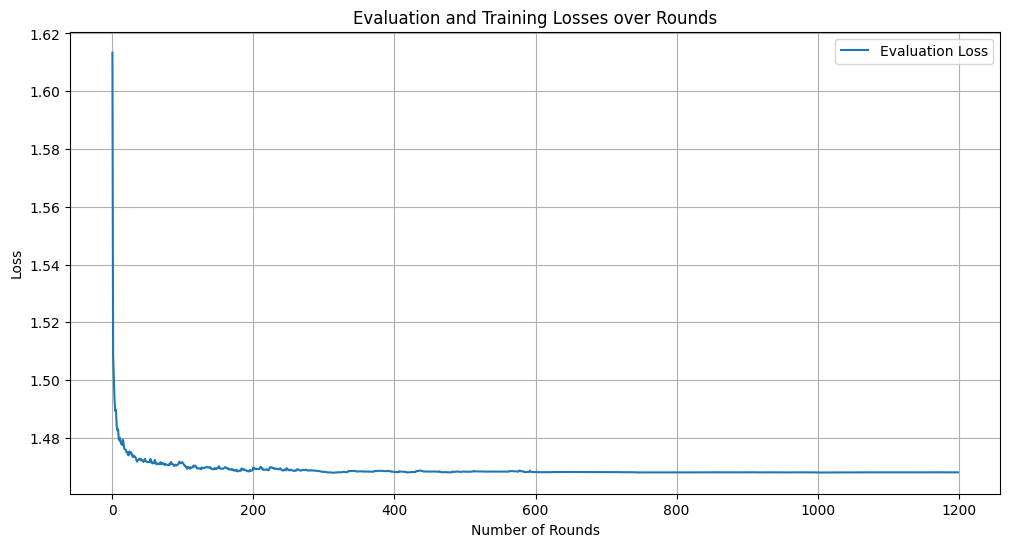

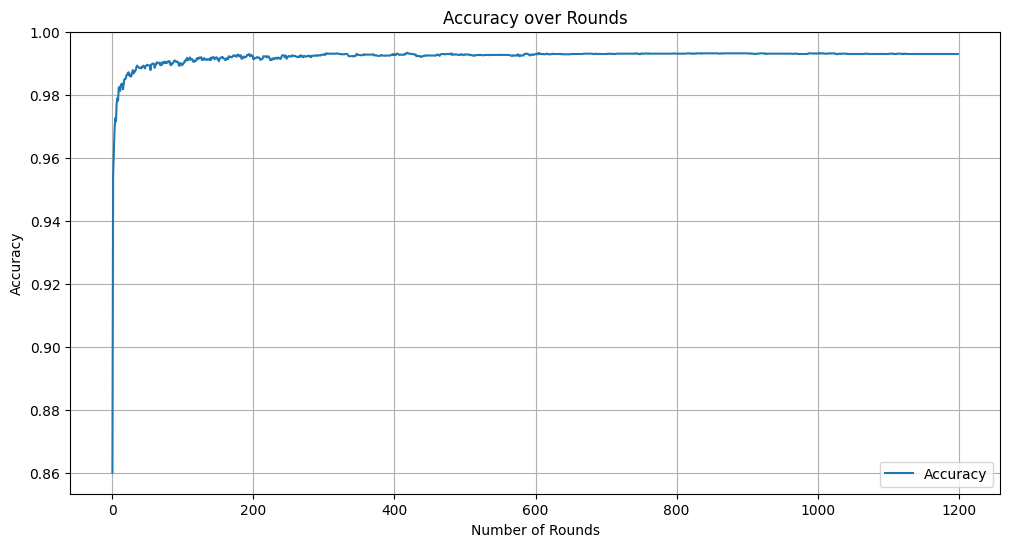

In [10]:
import matplotlib.pyplot as plt

# Plotting training and evaluation losses
plt.figure(figsize=(12, 6))
plt.plot(range(num_rounds), IID_eval_losses, label='Evaluation Loss')
#plt.plot(range(num_rounds), IID_avg_training_losses, label='Average Training Loss')
plt.xlabel('Number of Rounds')
plt.ylabel('Loss')
plt.title('Evaluation and Training Losses over Rounds')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(num_rounds), IID_accuracy_list, label='Accuracy')
plt.xlabel('Number of Rounds')
plt.ylabel('Accuracy')
plt.title('Accuracy over Rounds')
plt.legend()
plt.grid(True)
plt.show()


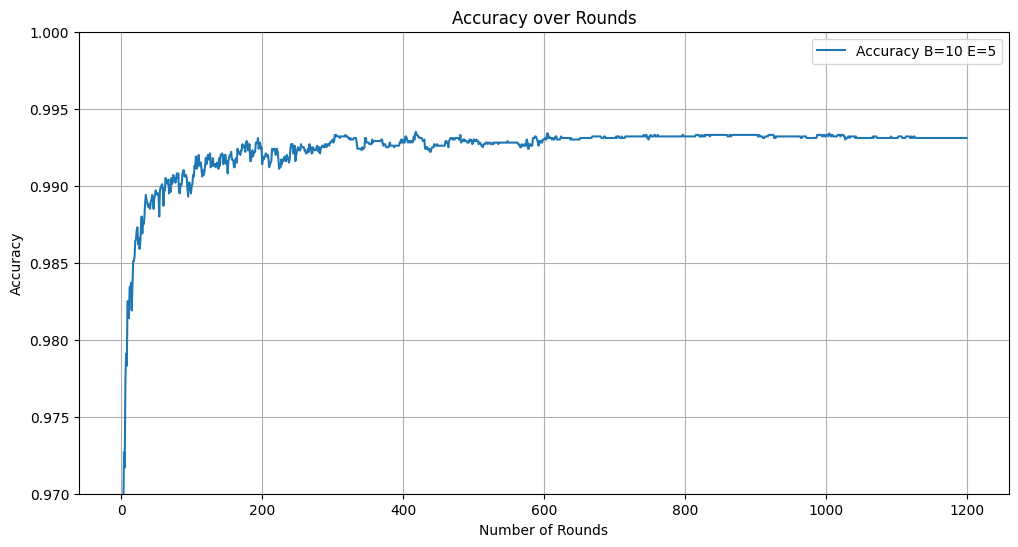

In [13]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(num_rounds), IID_accuracy_list, label='Accuracy B=10 E=5')
plt.xlabel('Number of Rounds')
plt.ylabel('Accuracy')
plt.title('Accuracy over Rounds')
plt.legend()
plt.ylim(0.970, 1.0)  # Set y-axis limits
plt.grid(True)
plt.show()